# Subselecting a Small Set to Reweight a Mixture for Search Depth

This notebook explores a procedure to subselect a small set of target keys from a large vocabulary, reweight a mixture-model representation for those targets, and measure search depth when attempting to match keys to the correct document. The data are heterogeneous (per-key counters, durations, and key sequences) and some sequences contain repeated observations; we show one practical approach for handling those counts.

## Objectives
- Subselect a manageable set of high-frequency keys to focus search and reweight mixture components.
- Fit a mixture/composite model to the heterogeneous observations (counter, timer, sequences).
- Encode sequences with aggregated observation counts and compute per-key posteriors.
- Measure and plot search depth (empirical CDF) for mixture-based ranking and a cosine-similarity baseline.

## Data
- Train/test splits are provided (TRAIN_DATA / TEST_DATA) and contain columns: key, counter, timer, key_sequence.
- Vocabulary is large; we restrict experiments to a top-N subset of keys (e.g., top 100 by observation count) and aggregate the remainder as "non-target".

## Approach (high level)
1. Load data and preprocess sequences by aggregating repeated observations into (token, count) pairs.
2. Build and fit mixture/composite estimators for the heterogeneous features.
3. Encode sequences and compute per-key mixture posteriors (reweighted for the selected subset).
4. Compute log-likelihoods and cosine similarities for test items against target key representations.
5. Plot histograms (counter, timer, sequence lengths) and empirical CDFs of search depth for comparison.

## Expected outputs
- Histograms for counters, timers, and sequence lengths.
- Per-key posterior weight matrix and test posterior encodings.
- Empirical CDF plots showing search depth for mixture ranking and cosine similarity ranking.
- Diagnostic prints/plots for assessing fit and search performance.

In [ ]:
from dmx.stats import * 

from dmx.utils.estimation import best_of, optimize
import numpy as np 
from numpy.random import RandomState
import os
import pandas as pd

import matplotlib.pyplot as plt

PATH_TO_DATA = "../data/subset_keys"
TRAIN_DATA = os.path.join(PATH_TO_DATA, "subset_keys_train.json")
TEST_DATA = os.path.join(PATH_TO_DATA, "subset_keys_test.json")

We can load in the data and take a look at the training set.

In [46]:
def load_data() -> tuple[pd.DataFrame, pd.DataFrame]:
    train_df = pd.read_csv(TRAIN_DATA)
    train_df["key_sequence"] = train_df["key_sequence"].apply(eval)

    test_df = pd.read_csv(TEST_DATA)
    test_df["key_sequence"] = test_df["key_sequence"].apply(eval)

    return train_df, test_df

train_df, test_df = load_data()

train_df.head()

,key,counter,timer,key_sequence
0,LNtu,13,27.832828,"[LVRq, TykY, MEit, ZsHO, PodL, MEit, CFll, MEi..."
1,LNtu,2,20.144842,"[yglJ, zPJp, JvRz, UjPZ, UjPZ, pnSZ, Hwts, irE..."
2,CFll,1,166.601950,"[BHFF, CjFR, xZoV, rKHS, NGNk, cEAS, iLit, iAf..."
3,IGzz,1,16.783352,"[qnkX, sOTr, Qnut, eCjU, zWBP, TRpd, qnkX, DBL..."
4,IGzz,2,4.223391,"[lEQa, HVSe, rgsI, LfOa, SHJi, WZxC, ozKf, ssj..."


The column `key` is going to correspond to the "vocabulary" we are interested in searching over. Let's see how many unique values exist in our vocabulary.

In [47]:
vocab = train_df["key"].unique().tolist()
print(f"Number of unique keys in the vocabular: {len(vocab)}")

Number of unique keys in the vocabular: 1000


Let's take a looks at the numeric data `counter` and `timer`. We can plot these variables and see if there are any observable trends that may be of use for building a model.

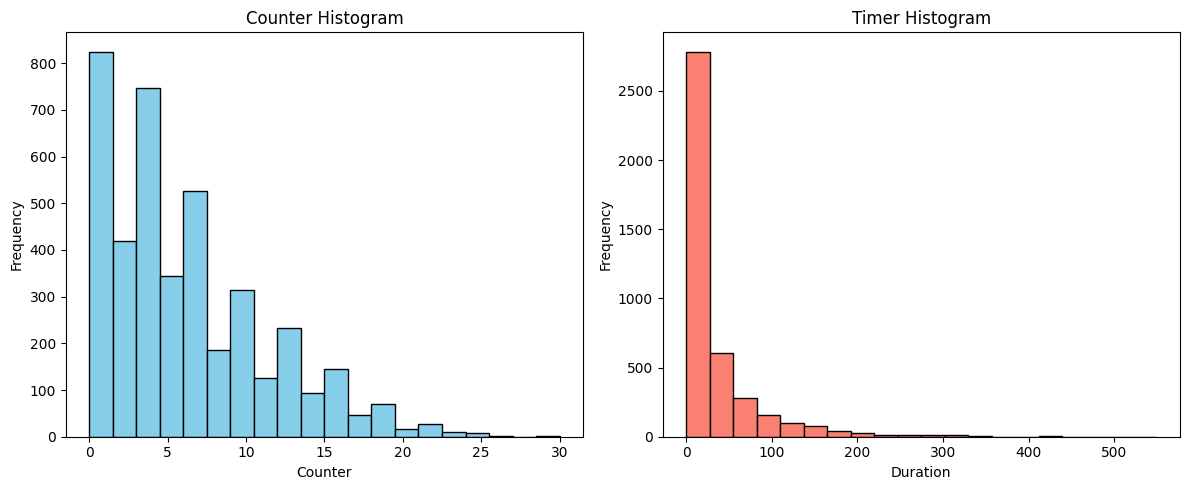

In [48]:
def plot_counter_duration_data(df: pd.DataFrame):
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram for "counter"
    axes[0].hist(df["counter"].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[0].set_title("Counter Histogram")
    axes[0].set_xlabel("Counter")
    axes[0].set_ylabel("Frequency")

    # Histogram for "duration"
    axes[1].hist(df["timer"].dropna(), bins=20, color='salmon', edgecolor='black')
    axes[1].set_title("Timer Histogram")
    axes[1].set_xlabel("Duration")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

plot_counter_duration_data(train_df)

We also have an observed value `key_sequence`. The sequences are varying length and should be composed of keys from the vocabulary.

In [49]:
def check_sequence_data(vocab) -> None:
    vocab_sequence = set()
    for x in train_df["key_sequence"].values:
        vocab_sequence.update(set(x))
    
    print(f"Sequence keys are a subset of vocab: {vocab_sequence.issubset(vocab)}")
    
check_sequence_data(vocab)

Sequence keys are a subset of vocab: True


Ok, so all the keys in the vocabulary are used to form the key sequences. Now let's take a look at what the lengths of the sequences.

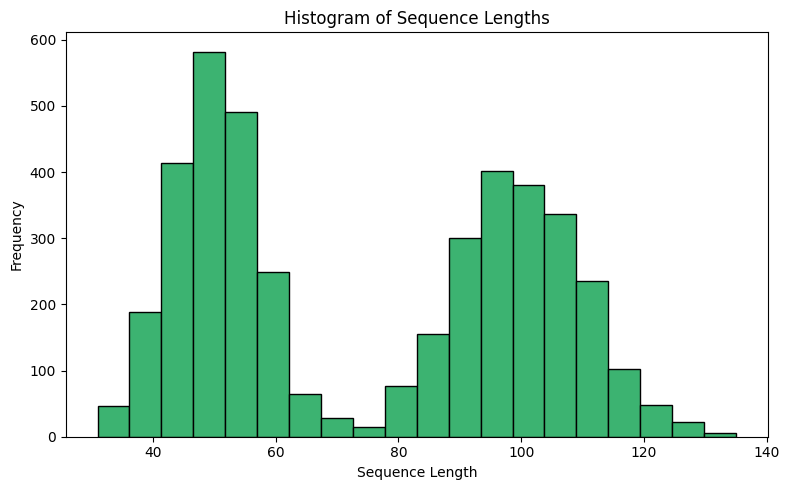

In [50]:
def plot_key_sequence_lengths(df):
    sequence_lengths = df["key_sequence"].apply(lambda x: len(x))
    plt.figure(figsize=(8, 5))
    plt.hist(sequence_lengths, bins=20, color='mediumseagreen', edgecolor='black')
    plt.title("Histogram of Sequence Lengths")
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_key_sequence_lengths(train_df)


The lengths of the sequences appear bi-modal. We can keep that in mind, as we will likely need to use a `MixtureEstimator` object to estimate a distribution for the lengths of the key sequences. 

One annoying thing that often comes up, is a count repetition. That is, we are often modeling a set of variables that have multiple repeated values. If we are willing to assume that the ordering of the sequence does not matter (i.e. no sequential dependence), we can use an estimator designed to handle value-counts.

Let's value-count our key sequences using `count_by_value`.

In [51]:
from dmx.utils.optsutil import count_by_value

train_df["key_value_counts"] = train_df["key_sequence"].apply(lambda x: [(k, v) for k, v in count_by_value(x).items()])
test_df["key_value_counts"] = test_df["key_sequence"].apply(lambda x: [(k, v) for k, v in count_by_value(x).items()])

Looking at `key_value_counts`, you should see that the keys of the sequence are now a `list[tuple[str, int]]`, where the second input corresponds to the observation count.

In [52]:
train_df.head()

,key,counter,timer,key_sequence,key_value_counts
0,LNtu,13,27.832828,"[LVRq, TykY, MEit, ZsHO, PodL, MEit, CFll, MEi...","[(LVRq, 2), (TykY, 1), (MEit, 4), (ZsHO, 1), (..."
1,LNtu,2,20.144842,"[yglJ, zPJp, JvRz, UjPZ, UjPZ, pnSZ, Hwts, irE...","[(yglJ, 1), (zPJp, 2), (JvRz, 1), (UjPZ, 4), (..."
2,CFll,1,166.601950,"[BHFF, CjFR, xZoV, rKHS, NGNk, cEAS, iLit, iAf...","[(BHFF, 5), (CjFR, 3), (xZoV, 1), (rKHS, 2), (..."
3,IGzz,1,16.783352,"[qnkX, sOTr, Qnut, eCjU, zWBP, TRpd, qnkX, DBL...","[(qnkX, 2), (sOTr, 1), (Qnut, 1), (eCjU, 1), (..."
4,IGzz,2,4.223391,"[lEQa, HVSe, rgsI, LfOa, SHJi, WZxC, ozKf, ssj...","[(lEQa, 1), (HVSe, 1), (rgsI, 1), (LfOa, 1), (..."


One last piece of this EDA that will come in to play when we fit the model is the number of counts per key. We can group the data by key value and get an idea of how many observations per key exist in the training set.

In [53]:
data_by_key = {}
for k in vocab:
    data_by_key[k] = train_df[train_df["key"] == k].drop(columns=["key", "key_sequence"]).values.tolist()

Let's take the top 100 keys with observation counts to be considered the "target" keys. We are going to lump everything else into its own pile and consider them "non-target" observations. 

In [54]:
# sort the keys by observation counts
sorted_key_counts = sorted([(k, len(v)) for k, v in data_by_key.items()], key=lambda x: x[1], reverse=True)
# get the top 100 keys. 
target_keys = [x for x, _ in sorted_key_counts[:100]]

Let's make a plot of the top 100 keys and their respective observtion counts. We will also plot the observation counts for each "non-target" key.

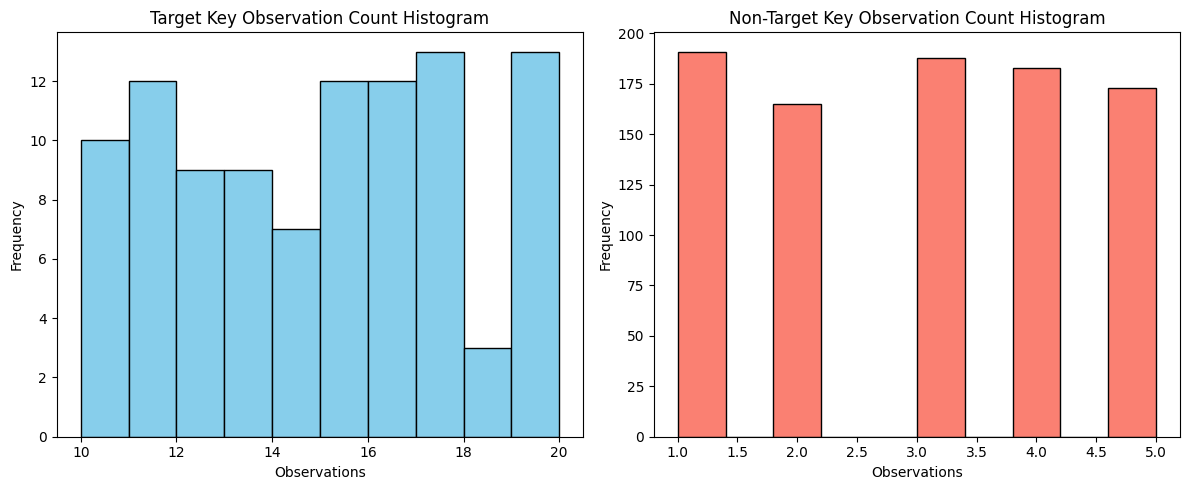

In [55]:
def make_key_count_plot(target_keys, sorted_key_counts):
    target_counts = []
    non_target_counts = []
    for k, v in sorted_key_counts:
        if k in target_keys:
            target_counts.append(v)
        else:
            non_target_counts.append(v)
    
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram for "counter"
    axes[0].hist(target_counts, color='skyblue', edgecolor='black')
    axes[0].set_title("Target Key Observation Count Histogram")
    axes[0].set_xlabel("Observations")
    axes[0].set_ylabel("Frequency")

    # Histogram for "duration"
    axes[1].hist(non_target_counts, color='salmon', edgecolor='black')
    axes[1].set_title("Non-Target Key Observation Count Histogram")
    axes[1].set_xlabel("Observations")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

make_key_count_plot(target_keys, sorted_key_counts)

Now that we have the data grouped by target and non-target keys, we can form a small validation set to help us fit the model. We will only select from the target keys for validation data. This will help us avoid throwing out unique user data for the non-target keys. 

In [56]:
def train_validation_split(data_dict: dict[str, list[int, float, list[tuple[str, int]]]], keys: list[str], seed: int):
    # take two samples from each of the target keys for a validation set. 
    train_data = []
    valid_data = []
    rng = RandomState(seed)

    for k, v in data_dict.items():
        if k in keys:
            w = [v[i] for i in rng.permutation(len(v))]
            valid_data.extend(w[:2])
            train_data.extend(w[2:])
        else:
            train_data.extend(v)

    return train_data, valid_data

train_data, valid_data = train_validation_split(data_by_key, target_keys, 1)

Now we are ready to build a model for the data. We will use a form a composite mixture and ignore the `key` variable when fitting the data. Let's recap the data to help pick estimators accordiningly:

- **counter** (`int`): Non-negative integer value.
- **timer** (`float`): Non-negative float value with lower bound of zero.
- **key_sequence** (`list[tuple[str, int]]`): List of value-counted keys (strings) on varying length.

We know we will write out a `MixtureEstimator` that wraps a `CompositeEstimator` to form our full estimator. First let's write down the **counter** and **timer** estimators.

In [57]:
est0 = PoissonEstimator() # Defined on non-negative integers
est1 = ExponentialEstimator() # Defined on postive reals

Now let us think a little bit about the estimator for the **key_sequence**. We know that we need a distribution that supports the data type `list[tuple[str, int]]`. We also need to think about a model that can handle varying sequence lengths. 

The `MultinomialEstimtor` will be the model of choice here. This estimator requires us to define two estimators:

- **estimator**: Estimator for the keys
- **len_estimator**: Estimator for the sequence lengths. 

We will use a `CategoricalEstimator` for the key estimator. We will pass in a `suff_stat` and `pseudo_count` to flatten the key values in the vocabulary.

In [58]:
word_est = CategoricalEstimator(suff_stat={k: 1.0 / len(vocab) for k in vocab}, pseudo_count=1.0e-16)

Our plot of the `key_sequence` lengths showed a clearly bi-modal distribution.

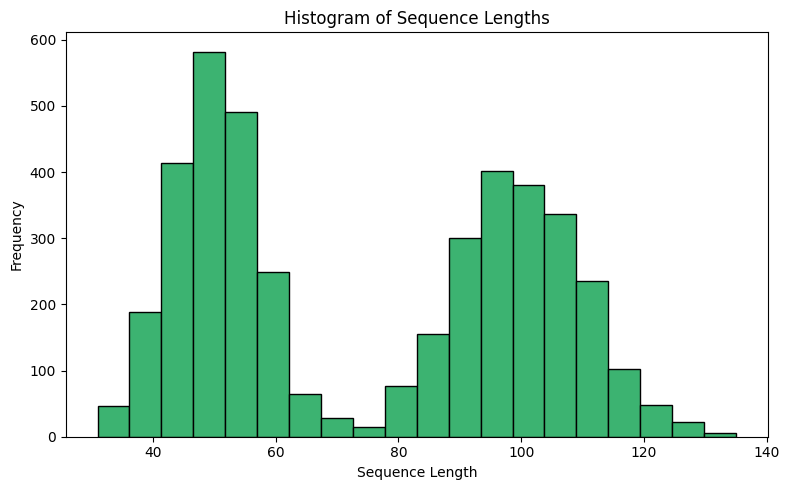

In [62]:
plot_key_sequence_lengths(train_df)

We need to keep in mind that length distributions must be defined on the non-negative integers. A good model to handle this is would be a mixture of Poisson distributions. Namely, we will have a two component mixture. 

In [59]:
len_est = MixtureEstimator([PoissonEstimator()]*2, keys=("w", "comps"))

Notice in the above we set `keys=("w", "comps")`. This was done to ensure that we only estimate one length distribution for the key sequences. 

We can now simply form a composite mixture from our defined estimators.

In [60]:
num_mix = 15
# multinomial estimator
est2 = MultinomialEstimator(estimator=word_est, len_estimator=len_est)
# composite for the data tuple
est3 = CompositeEstimator([est0, est1, est2])
# wrap it all in a mixture
est = MixtureEstimator([est3] * num_mix)

Alright, we have an estimator. Now we can run a few initial conditions to find the best fitting model on our validation set.

In [61]:
_, mm = best_of(
    data=train_data,
    est=est,
    trials=5,
    init_p=0.10,
    vdata=valid_data,
    delta=1.0e-6,
    max_its=25,
    print_iter=5,
    rng=np.random.RandomState(10)
)

Iteration 5. LL=-1831156.176649, delta LL=1.048252e+03
Iteration 10. LL=-1830713.441302, delta LL=3.365080e+00
Iteration 15. LL=-1830687.875979, delta LL=4.887295e+00
Iteration 20. LL=-1830679.224269, delta LL=1.094569e-02
Iteration 25. LL=-1830649.811745, delta LL=1.922715e-06
Trial 1. VLL=-94259.239770
Iteration 5. LL=-1830484.155831, delta LL=2.717111e+02
Iteration 10. LL=-1830166.031924, delta LL=3.519621e+01
Iteration 15. LL=-1830073.892545, delta LL=2.053950e+01
Iteration 20. LL=-1830018.692956, delta LL=6.972293e+00
Iteration 25. LL=-1829991.657891, delta LL=5.718255e+00
Trial 2. VLL=-94460.529915
Iteration 5. LL=-1830524.419384, delta LL=2.452027e+02
Iteration 10. LL=-1830053.562286, delta LL=5.299450e+01
Iteration 15. LL=-1829864.046719, delta LL=2.832492e+01
Iteration 20. LL=-1829710.065487, delta LL=2.797200e+01
Iteration 25. LL=-1829592.681374, delta LL=2.677647e+01
Trial 3. VLL=-94353.134211
Iteration 5. LL=-1831118.330398, delta LL=2.218883e+02
Iteration 10. LL=-1830863.2

Iterate a little more on the best model (if needed)...

In [63]:
fit = optimize(
    data=train_data,
    estimator=est,
    prev_estimate=mm,
    max_its=1000,
    print_iter=25)

Iteration 2: ln[p_mat(Data|Model)]=-1.830650e+06, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=2.328306e-10


Alright now that we have fit the model, it is time to evaluate the performance on the test set. To do this, we are going to enumerate the target keys (0-99) and all non-target keys in the test set will be designated key 100.

In [79]:
def process_test_data(test_df: pd.DataFrame, target_keys: list[str]):
    test_labels = test_df["key"].values.tolist()
    test_data = test_df.drop(columns=["key", "key_sequence"]).values.tolist()

    target_key_map = {k: i for i, k in enumerate(target_keys)}
    
    # append 100 for label outside the top 100
    test_labels = np.asarray([target_key_map.get(x, 100) for x in test_labels])

    return test_data, test_labels, target_key_map

test_data, test_labels, target_key_map = process_test_data(test_df, target_keys)

We will now use the key-grouped data to compute the expected number of times each component appears in their samples:
$$ E_t[P(z = i | x_t)] = \frac{1}{n}\sum_{t=1}^n \frac{\ell(x_t | z = i)\ell(z = i)}{\sum_{j = 1}^k \ell(x_t | z = j)\ell(z = j)}$$

In the following we compute the component distributions for the _training_ data. Note that this is done for all of the target keys (enumerated 0-99).

In [80]:
key_posteriors = np.zeros((101, num_mix))

for k in target_keys:
    enc_data = seq_encode(data=data_by_key[k], model=fit)[0][1]
    key_posteriors[target_key_map[k]] = np.mean(fit.seq_posterior(enc_data), axis=0)

We can repeat this calculation for the non-target keys. We are simply going to lump them all into one group and call this a single "non-target" key. 

In [81]:
def get_non_target_posterior():
    cnt = 0.0
    post = np.zeros(fit.num_components)
    for k, v in sorted_key_counts[100:]:
        if k not in target_keys:
            enc_data = seq_encode(data=data_by_key[k], model=fit)[0][1]
            
            post += np.sum(fit.seq_posterior(enc_data), axis=0)
            cnt += v
    
    return post / cnt

key_posteriors[100] = get_non_target_posterior()

We are now going to perform a search depth by examining each of the test observations. We will form a mixture model for each target key (and the non-target group) to compute the following conditional probabilities

$$\log{\left(\sum_{Z=1}^{15} P\left(\text{counter, timer, key sequence} | \text{Key} = k\right)\right)} = \log{\left(\sum_{Z=1}^{15} P\left(\text{counter, timer, key sequence} | Z=z) P(Z=z | \text{Key} = k\right)\right)}.$$

We can then rank the log-probabilities above in descending order to obtain a search-depth score for the correct key. This should give us an idea how well our model separates observations based on key values.

In [82]:
# encode the data for fast vectorized calls on the entire test data set all at once.
enc_test_data = seq_encode(data=test_data, model=fit)[0][1]
# we will store each target key's log-prob scores for all of the test data in the columns below
ll = np.zeros((len(test_data), len(target_keys)))
for _, i in target_key_map.items():
    # form a mixture with components estimated from the model and key based posteriors
    key_mixture = MixtureDistribution(components=fit.components, w=key_posteriors[i])
    # store log(P(test_data | key = k))
    ll[:, i] = key_mixture.seq_log_density(enc_test_data)

# sort the indicies of the most likely key for the each observation
key_ranks = np.argsort(-ll, axis=1)
# how far do i need to look to find the correct key (or non-target key)? 
sd = np.sort(np.argmax(key_ranks == test_labels[:, None], axis=1))

We can plot the search depth to see how well this model performs.

In [83]:
def plot_search_depth(search_depth):
    # Sort the search_depth for proper CDF plotting
    search_depth = np.sort(search_depth)
    sd_y = np.arange(1, len(search_depth) + 1) / len(search_depth)  # P(X <= x)

    # Append the point (100, 1.0)
    search_depth_extended = np.append(search_depth, 101)
    sd_y_extended = np.append(sd_y, 1.0)

    # Plot empirical CDF
    plt.figure(figsize=(8, 5))
    plt.plot(search_depth_extended, sd_y_extended, drawstyle="steps-post", linewidth=2)

    # Labels and title
    plt.xlabel("Number of Users", fontsize=12)
    plt.ylabel("P(X ≤ x)", fontsize=12)
    plt.title("User Search Depth", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.show()

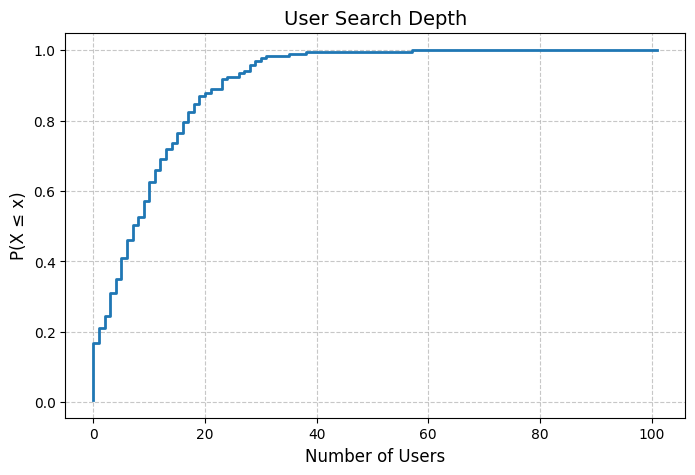

In [84]:
plot_search_depth(sd)

Alright, so it looks like we can place the correct key with a given observation in the top 20 90% of the time. 

Now in this particular example, we were able to construct the mixture distributions for each target key quite quickly. It was also fast to evaluate the search depth. In some cases, we may not be able to afford the computational bottle neck that comes here. One simple alternative is to compare cosine similarities of the posteriors of the test data with the key-posteriors. This should allow us to approximate search-depth quickly.

We can do this in a few quick steps. First, let's get the posteriors for the test data.

In [88]:
test_posteriors = fit.seq_posterior(enc_test_data)

Now we can simply compute a similarity matrix with the normalized vectors. The result should by an `n` by `101`, where `n` is the number of test samples.

In [89]:
# Normalize rows of both matrices
test_norm = test_posteriors / np.linalg.norm(test_posteriors, axis=1, keepdims=True)
key_norm = key_posteriors / np.linalg.norm(key_posteriors, axis=1, keepdims=True)

# Compute cosine similarity (n x m)
similarity_matrix = np.dot(test_norm, key_norm.T)

We can perform search depth across the rows of the similarity matrix as usual.

In [90]:
ranks_cosine = np.argmax(np.argsort(-similarity_matrix, axis=1) == test_labels[:, None], axis=1)
sd_cosine = np.sort(ranks_cosine)

Now we plot the search depths and compare the results. 

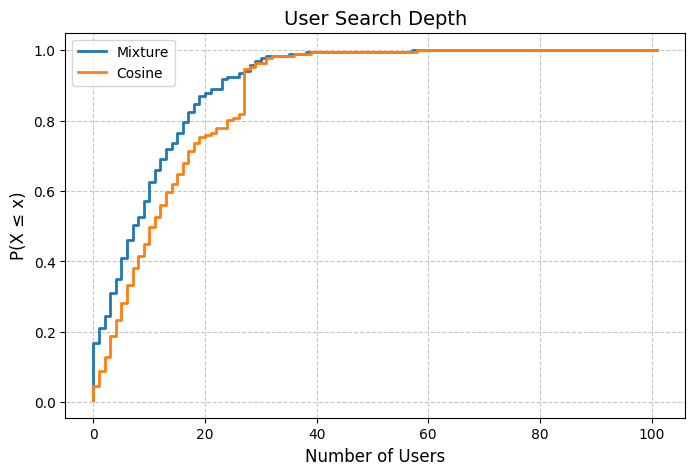

In [95]:
def plot_cosine_search_depth(search_depth_mixture, search_depth_cosine):
    # Sort the search_depth for proper CDF plotting
    sd_y = np.arange(1, len(search_depth_mixture) + 1) / len(search_depth_mixture)  # P(X <= x)

    # Append the point (100, 1.0)
    search_depth_extended = np.append(search_depth_mixture, 101)
    search_depth_cosine_extended = np.append(search_depth_cosine, 101)
    sd_y_extended = np.append(sd_y, 1.0)

    # Plot empirical CDF
    plt.figure(figsize=(8, 5))
    plt.plot(search_depth_extended, sd_y_extended, drawstyle="steps-post", linewidth=2, label="Mixture")
    plt.plot(search_depth_cosine_extended, sd_y_extended, drawstyle="steps-post", linewidth=2, label="Cosine")

    # Labels and title
    plt.xlabel("Number of Users", fontsize=12)
    plt.ylabel("P(X ≤ x)", fontsize=12)
    plt.title("User Search Depth", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.show()
plot_cosine_search_depth(search_depth_mixture=sd, search_depth_cosine=sd_cosine)

It looks like the cosine similarity scores did pretty well as a surrogate for the conditional probabilities. This is expected, and should be considered when obtaining the full conditional probabilties is costly. 